# More Advanced Kaggle Starter for House of Blocks Kaggle In-Class Competition

This workbook is a starter code for the [Kaggle In-Class House of Blocks Competition](https://www.kaggle.com/c/applications-of-deep-learning-wustl-fall-2020)  This competition is one of the assignments for [T81-558: Applications of Deep Neural Netw1orks](https://sites.wustl.edu/jeffheaton/t81-558/) at [Washington University in St. Louis](https://www.wustl.edu).

This notebook gets a better score than my previous starter, by using transfer learning.  The notebook also implements basic feature importance. 

In [1]:
import numpy as np
import pandas as pd
import os

PATH = "/kaggle/input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data/"
PATH_TRAIN = os.path.join(PATH, "train.csv")
PATH_TEST = os.path.join(PATH, "test.csv")

Next we check versions and if the GPU is available. 

In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() \
      else "NOT AVAILABLE")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
Pandas 1.1.1
Scikit-Learn 0.23.2
GPU is available


Next, we prepare to read the training data (that we have labels for) and the test data that we must predict and send to Kaggle.

In [3]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

df_train = df_train[df_train.id != 1300]

df_train['filename'] = df_train["id"].astype(str)+".png"
df_train['stable'] = df_train['stable'].astype(str)

df_test['filename'] = df_test["id"].astype(str)+".png"

Perform a basic balance plot.  This data is fairly well balanced.

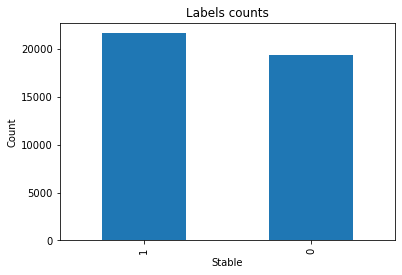

In [4]:
import matplotlib.pyplot as plt

df_train.stable.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Stable')
plt.ylabel('Count')
plt.show()

We want to use early stopping.  To do this, we need a validation set.  We will break the data into 80 percent test data and 20 validation.  Do not confuse this validation data with the test set provided by Kaggle.  This validation set is unique to your program and is just used for early stopping.

In [9]:
# subset
# df_train_sub = df_train.head(4098)

In [5]:
# add subset!!!!
TRAIN_PCT = 0.9
TRAIN_CUT = int(len(df_train) * TRAIN_PCT)

df_train_cut = df_train[0:TRAIN_CUT]
df_validate_cut = df_train[TRAIN_CUT:]

print(f"Training size: {len(df_train_cut)}")
print(f"Validate size: {len(df_validate_cut)}")

Training size: 36882
Validate size: 4099


Next, we create the generators that will provide the images to the neural network as it is trained.  We normalize the images so that the RGB colors between 0-255 become ratios between 0 and 1.  We also use the **flow_from_dataframe** generator to connect the Pandas dataframe to the actual image files. We see here a straightforward implementation; you might also wish to use some of the image transformations provided by the data generator.

The **HEIGHT** and **WIDTH** constants specify the dimensions that the image will be scaled (or expanded) to. It is probably not a good idea to expand the images.

In [6]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

WIDTH = 224
HEIGHT = 224

training_datagen = ImageDataGenerator(
  rescale = 1./255,
  #horizontal_flip=True,
  #vertical_flip=True,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        batch_size=32,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        batch_size=32,
        class_mode='categorical')

Found 36882 validated image filenames belonging to 2 classes.
Found 4099 validated image filenames belonging to 2 classes.


We now create the neural network and fit it.  Some essential concepts are going on here.

* **Batch Size** - The number of training samples that should be evaluated per training step.  Smaller batch sizes, or mini-batches, are generally preferred.
* **Step** - A training step is one complete run over the batch.  At the end of a step, the weights are updated, and the neural network learns.
* **Epoch** - An arbitrary point at which to measure results or checkpoint the model.  Generally, an epoch is one complete pass over the training set.  However, when generators are used, the training set size is theoretically infinite. Because of this, we set a **steps_per_epoch** parameter.
* **validation steps** - The validation set may also be infinite; because of this, we must specify how many steps we wish to validate at the end of each Epoch.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(include_top=False)
base_model.trainable = True
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
x=Dense(256,activation='relu')(x)
# preds=Dense(1,activation="sigmoid")(x)
preds=Dense(2,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=preds)
model.summary()


# base_model=MobileNet(weights='imagenet',include_top=False,alpha = 1.0,dropout = 0.3,) 

# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) 
# x=Dense(1024,activation='relu')(x) 
# preds=Dense(2,activation='softmax')(x)

# model=Model(inputs=base_model.input,outputs=preds)

# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True

# model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [8]:
# import matplotlib.pyplot as plt
# import keras.backend as K
# from keras.callbacks import Callback


# class LRFinder(Callback):
    
#     '''
#     A simple callback for finding the optimal learning rate range for your model + dataset. 
    
#     # Usage
#         ```python
#             lr_finder = LRFinder(min_lr=1e-5, 
#                                  max_lr=1e-2, 
#                                  steps_per_epoch=np.ceil(epoch_size/batch_size), 
#                                  epochs=3)
#             model.fit(X_train, Y_train, callbacks=[lr_finder])
            
#             lr_finder.plot_loss()
#         ```
    
#     # Arguments
#         min_lr: The lower bound of the learning rate range for the experiment.
#         max_lr: The upper bound of the learning rate range for the experiment.
#         steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
#         epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
#     # References
#         Blog post: jeremyjordan.me/nn-learning-rate
#         Original paper: https://arxiv.org/abs/1506.01186
#     '''
    
#     def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
#         super().__init__()
        
#         self.min_lr = min_lr
#         self.max_lr = max_lr
#         self.total_iterations = steps_per_epoch * epochs
#         self.iteration = 0
#         self.history = {}
        
#     def clr(self):
#         '''Calculate the learning rate.'''
#         x = self.iteration / self.total_iterations 
#         return self.min_lr + (self.max_lr-self.min_lr) * x
        
#     def on_train_begin(self, logs=None):
#         '''Initialize the learning rate to the minimum value at the start of training.'''
#         logs = logs or {}
#         K.set_value(self.model.optimizer.lr, self.min_lr)
        
#     def on_batch_end(self, epoch, logs=None):
#         '''Record previous batch statistics and update the learning rate.'''
#         logs = logs or {}
#         self.iteration += 1

#         self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#         self.history.setdefault('iterations', []).append(self.iteration)

#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
            
#         K.set_value(self.model.optimizer.lr, self.clr())
 
#     def plot_lr(self):
#         '''Helper function to quickly inspect the learning rate schedule.'''
#         plt.plot(self.history['iterations'], self.history['lr'])
#         plt.yscale('log')
#         plt.xlabel('Iteration')
#         plt.ylabel('Learning rate')
#         plt.show()
        
#     def plot_loss(self):
#         '''Helper function to quickly observe the learning rate experiment results.'''
#         plt.plot(self.history['lr'], self.history['loss'])
#         plt.xscale('log')
#         plt.xlabel('Learning rate')
#         plt.ylabel('Loss')
#         plt.show()

In [12]:
import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

# model.fit(X_train, Y_train, callbacks=[lr_sched])

In [13]:
validation_steps = len(df_validate_cut)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
history = model.fit(train_generator, epochs=25, steps_per_epoch=250, 
                    validation_data = val_generator, 
                    verbose = 1, validation_steps=20,callbacks=[lr_sched])


Epoch 1/25
250/250 [==============================] - 158s 632ms/step - loss: 0.7003 - accuracy: 0.5391 - val_loss: 0.6806 - val_accuracy: 0.5656
Epoch 2/25
250/250 [==============================] - 152s 607ms/step - loss: 0.6279 - accuracy: 0.6220 - val_loss: 0.6228 - val_accuracy: 0.6453
Epoch 3/25
250/250 [==============================] - 147s 587ms/step - loss: 0.5596 - accuracy: 0.6865 - val_loss: 0.6802 - val_accuracy: 0.6250
Epoch 4/25
250/250 [==============================] - 145s 580ms/step - loss: 0.4426 - accuracy: 0.7734 - val_loss: 0.6930 - val_accuracy: 0.7266
Epoch 5/25
250/250 [==============================] - 141s 565ms/step - loss: 0.3131 - accuracy: 0.8468 - val_loss: 0.4696 - val_accuracy: 0.8125
Epoch 6/25
250/250 [==============================] - 139s 555ms/step - loss: 0.2497 - accuracy: 0.8787 - val_loss: 0.4379 - val_accuracy: 0.8047
Epoch 7/25
250/250 [==============================] - 141s 565ms/step - loss: 0.2096 - accuracy: 0.9043 - val_loss: 0.4701 -

# Feature Importance

We will use the [Grad-CAM algorithm](https://keras.io/examples/vision/grad_cam/) to determine feature importance for a few images.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [21]:
# Activation for last CONV layer.
last_conv_layer_name = "out_relu"


classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_3",
    "dense_4",
    "dense_5",
]

In [22]:
def process_grad_cam(filename):
    img_path = os.path.join(PATH, filename)
    img_array = get_img_array(img_path, size=(HEIGHT, WIDTH))
    img_array /= 255.0
    preds = model.predict(img_array)
    print(f"Prediction: {preds}")
    #img = Image(img_path)
    #display(img)
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )
    plt.matshow(heatmap)
    plt.show()

    # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    display(superimposed_img)

Prediction: [[9.99988079e-01 1.19768465e-05]]


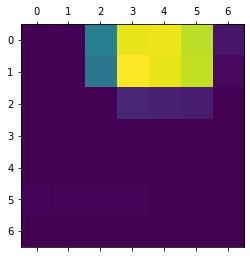

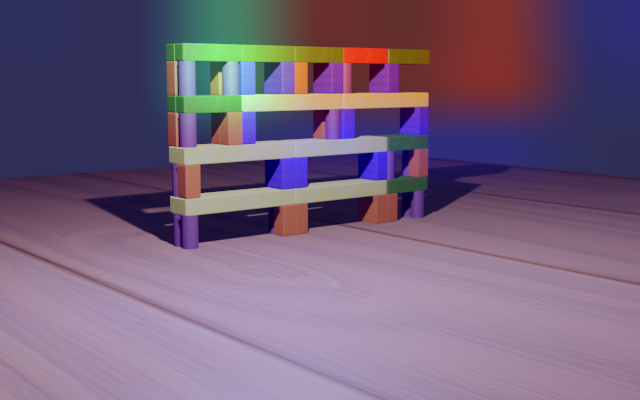

In [23]:
# Unstable
process_grad_cam("8.png")

Prediction: [[0.00180377 0.9981963 ]]


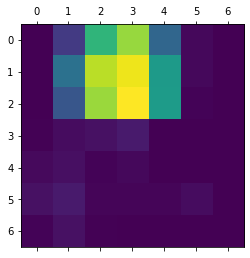

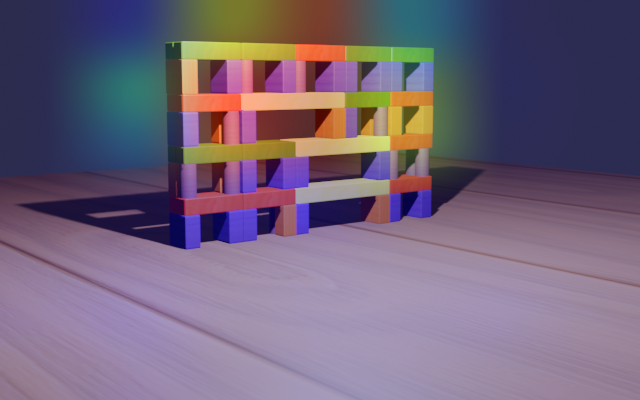

In [24]:
# Stable
process_grad_cam("1.png")

# Build Submission

Now that the neural network is trained; we need to generate a submit CSV file to send to Kaggle.  We will use nearly the same technique to build the submit file.  However, these essential points that we must address:

* We do not want the data generator to create an infinite date like we did when training.  We have a fixed number of cases to score for the Kaggle submit; we only want to process them.
* We do not want the data generator to randomize the samples' order like it did when training. Therefore we set shuffle to false.
* We want to always start at the beginning of the data, so we reset the generator.

These ensure that the predictions align with the id's.

In [25]:
submit_datagen = ImageDataGenerator(rescale = 1./255)

submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

submit_generator.reset()
pred = model.predict(submit_generator,steps=len(df_test))


Found 10294 validated image filenames.


In [27]:
# modeified !!!
df_submit = pd.DataFrame({"id":df_test['id'],'stable':pred[:,1].flatten()})
df_submit.to_csv("/kaggle/working/submit_dense_2.csv",index = False)

In [ ]:
df_submit

In [2]:
PATH = "/kaggle/input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data/"
PATH_TRAIN = os.path.join(PATH, "train.csv")
PATH_TEST = os.path.join(PATH, "test.csv")
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [ ]:
df_train.to_csv("/kaggle/working/train.csv",index = False)
df_test.to_csv("/kaggle/working/test.csv",index = False)